In [1]:
import dowel_wrapper

2024-07-03 12:58:52.497471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 12:58:54.830492: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 12:58:56.537726: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 12:59:03.884993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
import pickle
import torch
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from envs.mujoco.ant_env import AntEnv

In [3]:
EXP_ROOT = 'exp/ant_l2_penalty_with_fixed_lambda_0.5_unnormalized_z/sd000_s_57262936.0.1719515965_ant_metra/'

In [4]:
# load itr pkl file
with open(os.path.join(EXP_ROOT, 'itr_100000.pkl'), 'rb') as f:
    itr = pickle.load(f)

XDG_RUNTIME_DIR (/tmp) is not owned by us (uid 157674), but by uid 0! (This could e.g. happen if you try to connect to a non-root PulseAudio as a root user, over the native protocol. Don't do that.)
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2675:(snd_pcm_open_noupdate) Unknown PCM default
XDG_RUNTIME_DIR (/tmp) is not owned by us (uid 157674), but by uid 0! (This could e.g. happen if you try to connect to a non-root 

In [5]:
algo = itr['algo']
algo.device = 'cpu'
algo.option_policy._module.to('cpu')

GaussianMLPTwoHeadedModuleEx(
  (_shared_mean_log_std_network): MultiHeadedMLPModule(
    (_layers): ModuleList(
      (0): Sequential(
        (linear): Linear(in_features=31, out_features=1024, bias=True)
        (non_linearity): <built-in method tanh of type object at 0x154546982840>
      )
      (1): Sequential(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (non_linearity): <built-in method tanh of type object at 0x154546982840>
      )
    )
    (_output_layers): ModuleList(
      (0-1): 2 x Sequential(
        (linear): Linear(in_features=1024, out_features=8, bias=True)
      )
    )
  )
)

In [6]:
# load trajectory network
traj_data = torch.load(os.path.join(EXP_ROOT, 'traj_encoder100000.pt'))
traj_encoder = traj_data['traj_encoder']
traj_encoder.to('cpu')
traj_encoder.eval()

GaussianMLPIndependentStdModuleEx(
  (_mean_module): MLPModule(
    (_layers): ModuleList(
      (0): Sequential(
        (linear): Linear(in_features=29, out_features=1024, bias=True)
        (non_linearity): <built-in method relu of type object at 0x154546982840>
      )
      (1): Sequential(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (non_linearity): <built-in method relu of type object at 0x154546982840>
      )
    )
    (_output_layers): ModuleList(
      (0): Sequential(
        (linear): Linear(in_features=1024, out_features=2, bias=True)
      )
    )
  )
  (_log_std_module): MLPModule(
    (_layers): ModuleList(
      (0): Sequential(
        (linear): Linear(in_features=29, out_features=1024, bias=True)
        (non_linearity): <built-in method relu of type object at 0x154546982840>
      )
      (1): Sequential(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (non_linearity): <built-in method relu of ty

In [7]:
# load option policy
option_data = torch.load(os.path.join(EXP_ROOT, 'option_policy100000.pt'))
option_policy = option_data['policy']
option_policy.to('cpu')
option_policy.eval()

PolicyEx(
  (_module): GaussianMLPTwoHeadedModuleEx(
    (_shared_mean_log_std_network): MultiHeadedMLPModule(
      (_layers): ModuleList(
        (0): Sequential(
          (linear): Linear(in_features=31, out_features=1024, bias=True)
          (non_linearity): <built-in method tanh of type object at 0x154546982840>
        )
        (1): Sequential(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (non_linearity): <built-in method tanh of type object at 0x154546982840>
        )
      )
      (_output_layers): ModuleList(
        (0-1): 2 x Sequential(
          (linear): Linear(in_features=1024, out_features=8, bias=True)
        )
      )
    )
  )
)

In [8]:
env = AntEnv(render_hw=100)
init_obs = env.reset()

# make sure ant is floating in the air by stepping a few times
for _ in range(10):
    obs, *_ = env.step(np.zeros_like(env.action_space.shape))

In [9]:
# create meshgrid of observations
xs = np.linspace(-40, 40)
ys = np.linspace(-40, 40)
X, Y = np.meshgrid(xs, ys)

obs_mean = np.array(
    [0.00486117, 0.011312, 0.7022248, 0.8454677, -0.00102548, -0.00300276, 0.00311523, -0.00139029,
     0.8607109, -0.00185301, -0.8556998, 0.00343217, -0.8585605, -0.00109082, 0.8558013, 0.00278213,
     0.00618173, -0.02584622, -0.00599026, -0.00379596, 0.00526138, -0.0059213, 0.27686235, 0.00512205,
     -0.27617684, -0.0033233, -0.2766923, 0.00268359, 0.27756855])
obs_var = np.array(
    [0.62473416, 0.61958003, 0.1717569, 0.28629342, 0.20020866, 0.20572574, 0.34922406, 0.40098143,
     0.3114514, 0.4024826, 0.31057045, 0.40343934, 0.3110796, 0.40245822, 0.31100526, 0.81786263, 0.8166509,
     0.9870919, 1.7525449, 1.7468817, 1.8596431, 4.502961, 4.4070187, 4.522444, 4.3518476, 4.5105968,
     4.3704205, 4.5175962, 4.3704395]) ** 2

all_obs = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i][j]
        y = Y[i][j]
        new_obs = np.copy(obs)
        new_obs[0] = x
        new_obs[1] = y
        all_obs.append((new_obs - obs_mean) / (np.sqrt(obs_var) + 1e-8))

all_obs = torch.from_numpy(np.stack(all_obs)).float()
all_obs.shape

torch.Size([2500, 29])

In [10]:
with torch.no_grad():
    phis = traj_encoder(all_obs).mean.numpy()
phi_norms = np.square(phis).sum(axis=-1)

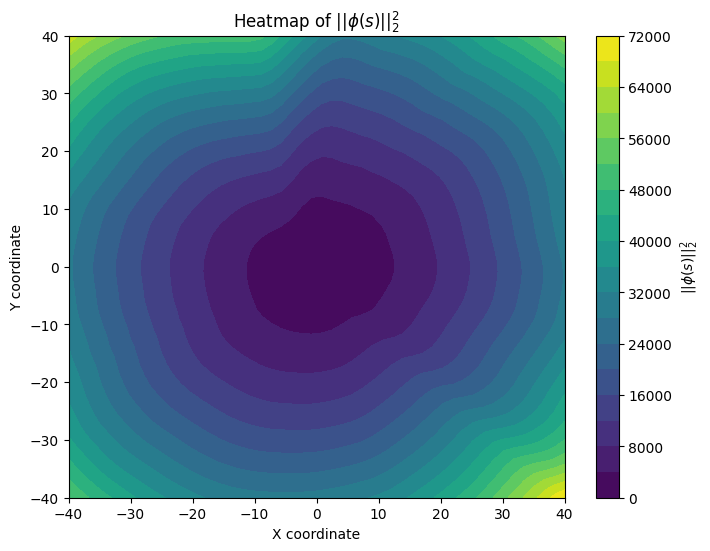

In [11]:
# plot heatmap of ||phi||_2^2
plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.contourf(X, Y, phi_norms.reshape(X.shape[0], Y.shape[0]), 20, cmap='viridis')  # Create a filled contour plot (heatmap)
plt.colorbar(label='$||\phi(s)||_2^2$')  # Add a colorbar to interpret the colors
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Heatmap of $||\phi(s)||_2^2$')
plt.show()

In [12]:
# load replay samples
samples = itr['replay_buffer_samples']
samples['obs'].shape

(10000, 29)

In [13]:
# send replay samples through network
with torch.no_grad():
    phis_replay = traj_encoder(torch.from_numpy(samples['obs']).float()).mean.numpy()
    phisp_replay = traj_encoder(torch.from_numpy(samples['next_obs']).float()).mean.numpy()
    
# save as npy
samples['obs'].shape
samples['options'].shape
np.save('obs_metra_l2_unnormalized_z.npy', samples['obs'])
np.save('next_obs_metra_l2_unnormalized_z.npy', samples['next_obs'])
np.save('phis_metra_l2_unnormalized_z.npy', phis_replay)
np.save('phisp_metra_l2_unnormalized_z.npy', phisp_replay)
np.save('options_metra_l2_unnormalized_z.npy', samples['options'])

In [14]:
# fit kernel density estimator
# “scott”, “silverman”
kde = KernelDensity(bandwidth="scott").fit(phis_replay)

In [15]:
# score meshgrid representations using KDE
kde_scores = kde.score_samples(phis)

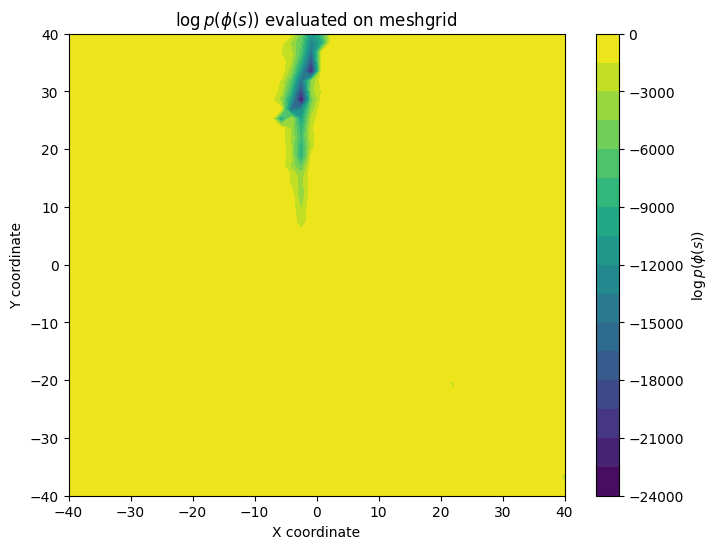

In [16]:
# plot heatmap of log p(\phi(s))
plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.contourf(X, Y, kde_scores.reshape(X.shape[0], X.shape[1]), 20, cmap='viridis')  # Create a filled contour plot (heatmap)
plt.colorbar(label='$\log p(\phi(s))$')  # Add a colorbar to interpret the colors
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('$\log p(\phi(s))$ evaluated on meshgrid')
plt.show()

In [17]:
def make_env():
    from iod.utils import get_normalizer_preset
    from garagei.envs.consistent_normalized_env import consistent_normalize
    # from envs.mujoco.ant_env import AntEnv
    from envs.mujoco.ant_env import AntEnv
    env = AntEnv(render_hw=100)

    normalizer_name = 'ant'
    normalizer_type = 'preset'
    normalizer_kwargs = {}
    if normalizer_type == 'off':
        env = consistent_normalize(env, normalize_obs=False, **normalizer_kwargs)
    else:
        normalizer_mean, normalizer_std = get_normalizer_preset(f'{normalizer_name}_preset')
        env = consistent_normalize(env, normalize_obs=True, mean=normalizer_mean, std=normalizer_std, **normalizer_kwargs)

    return env

def _get_trajectories(runner,
                        sampler_key,
                        batch_size=None,
                        extras=None,
                        update_stats=False,
                        worker_update=None,
                        env_update=None):
    if batch_size is None:
        batch_size = len(extras)
    policy_sampler_key = sampler_key[6:] if sampler_key.startswith('local_') else sampler_key
    time_get_trajectories = [0.0]

    trajectories, infos = runner.obtain_exact_trajectories(
        runner.step_itr,
        sampler_key=sampler_key,
        batch_size=batch_size,
        agent_update=_get_policy_param_values({'option_policy':option_policy}, policy_sampler_key),
        env_update=env_update,
        worker_update=worker_update,
        extras=extras,
        update_stats=update_stats,
    )
    print(f'_get_trajectories({sampler_key}) {time_get_trajectories[0]}s')

    for traj in trajectories:
        for key in ['ori_obs', 'next_ori_obs', 'coordinates', 'next_coordinates']:
            if key not in traj['env_infos']:
                continue

    return trajectories

def _get_policy_param_values(policy, key):
    param_dict = policy[key].get_param_values()
    for k in param_dict.keys():
        param_dict[k] = param_dict[k].detach().cpu()
    return param_dict

def _generate_option_extras(options):
    return [{'option': option} for option in options]


In [18]:
from iod.utils import get_option_colors
import dowel_wrapper
assert dowel_wrapper is not None
import dowel
from garagei.experiment.option_local_runner import OptionLocalRunner
from garaged.src.garage.experiment.experiment import ExperimentContext
from garagei.sampler.option_multiprocessing_sampler import OptionMultiprocessingSampler
from iod.utils import get_torch_concat_obs, FigManager

NUM_RANDOM_TRAJECTORIES = 100

random_options = np.random.randn(NUM_RANDOM_TRAJECTORIES, 2)
random_options = random_options / np.linalg.norm(random_options, axis=1, keepdims=True)
random_option_colors = get_option_colors(random_options * 4)

# for some reasons things are saved in ./plots/
runner = OptionLocalRunner(ExperimentContext(
    snapshot_dir='.',
    snapshot_mode='last',
    snapshot_gap=1,
))

env = make_env()
contextualized_make_env = make_env

runner.setup(
    algo=algo,
    env=env,
    make_env=contextualized_make_env,
    sampler_cls=OptionMultiprocessingSampler,
    sampler_args=dict(n_thread=1),
    n_workers=1,
)

random_trajectories = _get_trajectories(
    runner,
    sampler_key='option_policy',
    extras=_generate_option_extras(random_options),
    batch_size=NUM_RANDOM_TRAJECTORIES,
    worker_update=dict(
        _render=False,
        _deterministic_policy=True,
    ),
    env_update=dict(_action_noise_std=None),
)

with FigManager(runner, 'random_trajectory') as fm:
    runner._env.render_trajectories(
        random_trajectories, random_option_colors, [-40, 40, -40, 40], fm.ax
    )


Sampling
_get_trajectories(option_policy) 0.0s


In [33]:
# compute phi(s') - phi(s) - z from replay and visualize density
with torch.no_grad():
    phisp_replay = traj_encoder(torch.from_numpy(samples['next_obs']).float()).mean.numpy()
    
z_replay = samples['options']

phisp_phis_z_replay = phisp_replay - phis_replay - z_replay
phisp_phis_replay = phisp_replay - phis_replay
phisp_phis_replay_squared_norm = np.square(phisp_replay - phis_replay).sum(axis=-1)
phisp_dot_phis_replay = (phisp_replay * phis_replay).sum(axis=-1)
phis_squared_norm = np.square(phis_replay).sum(axis=-1)
phisp_squared_norm = np.square(phisp_replay).sum(axis=-1)
phis_norm = np.sqrt(phis_squared_norm)
phisp_norm = np.sqrt(phisp_squared_norm)
phisp_norm_phis_norm_squared = (phisp_norm - phis_norm)**2
cos = phisp_dot_phis_replay / phis_norm / phisp_norm
print(cos)
print(phisp_norm - phis_norm)
print(phisp_squared_norm - phis_squared_norm)
print(phisp_dot_phis_replay)
print(phis_squared_norm)
print(phisp_squared_norm)
phisp_phis_replay_norm = np.square(phisp_replay - phis_replay).sum(axis=-1)

# compute norms of z_replay
z_replay_norms = np.linalg.norm(z_replay, axis=-1)
z_replay_norms

[0.99999404 1.0000001  0.9999816  ... 1.         0.9999996  0.99992174]
[ 1.4244385   1.5288239   1.1453133  ...  0.45671082  1.2545471
 -0.0170244 ]
[ 2.7193066e+02  5.0306250e+02  5.5373718e+01 ...  2.0564062e+02
  4.3052539e+02 -6.1221600e-02]
[9.1104551e+03 2.7067969e+04 5.8404761e+02 ... 5.0686066e+04 2.9440715e+04
 3.2326753e+00]
[8.9755586e+03 2.6817605e+04 5.5702740e+02 ... 5.0583352e+04 2.9226252e+04
 3.2636843e+00]
[9.2474893e+03 2.7320668e+04 6.1240112e+02 ... 5.0788992e+04 2.9656777e+04
 3.2024627e+00]


array([1.26960797, 1.26931623, 1.2697193 , ..., 1.41703668, 0.92763859,
       0.15989094])

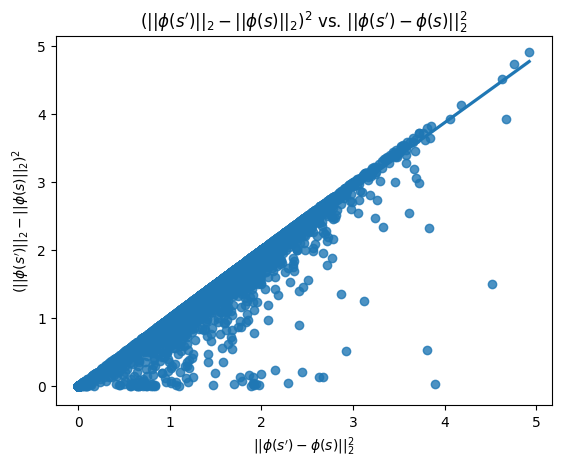

In [36]:
# plot correlation between (||phi(s')||_2 - ||phi(s)||_2)^2 and ||phi(s') - phi(s)||_2^2
sns.regplot(x=phisp_phis_replay_squared_norm, y=phisp_norm_phis_norm_squared)
plt.xlabel("$||\phi(s') - \phi(s)||_2^2$")
plt.ylabel("$(||\phi(s')||_2 - ||\phi(s)||_2)^2$")
plt.title("$(||\phi(s')||_2 - ||\phi(s)||_2)^2$ vs. $||\phi(s') - \phi(s)||_2^2$")
plt.show()

In [20]:
# check if phi(s') - phi(s) - z is Gaussian using swd
import ot

# produce some Gaussian samples
sigma = np.sqrt(1/(phisp_phis_z_replay.shape[0] * phisp_phis_z_replay.shape[1]) * np.square(phisp_phis_z_replay).sum(axis=-1).sum())
normal_samples_1 = np.random.normal(scale=sigma, size=(10000,2))
normal_samples_2 = np.random.normal(scale=sigma, size=(10000,2))
print(normal_samples_1.shape)
swd_ref = ot.sliced_wasserstein_distance(normal_samples_1, normal_samples_2, n_projections=1000)
print(f'Reference SWD: {swd_ref}')
swd_phisp_phis_z_replay = ot.sliced_wasserstein_distance(phisp_phis_z_replay, normal_samples_1, n_projections=1000)
print(f"SWD to phi(s') - phi(s) - z: {swd_phisp_phis_z_replay}")

(10000, 2)
Reference SWD: 0.016560465911409153
SWD to phi(s') - phi(s) - z: 0.07476070582160511


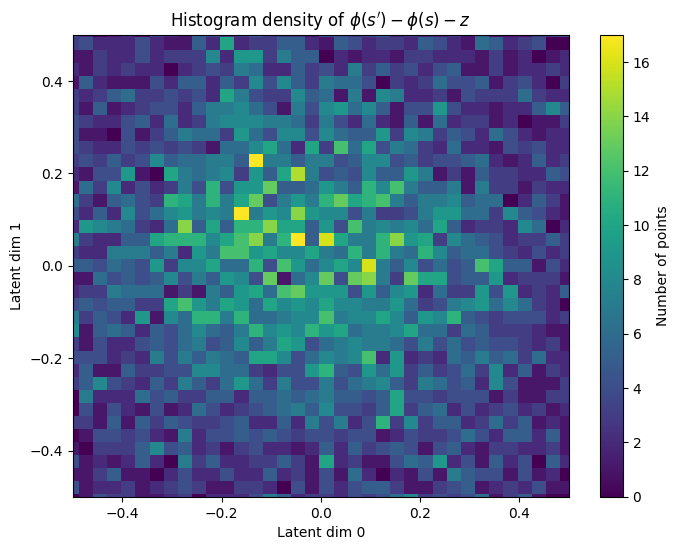

In [21]:
# plot 2d histogram
# Define the number of bins in each dimension
num_bins = 200

# Create the 2D histogram
plt.figure(figsize=(8, 6))  # Optional: set the figure size
X = phisp_phis_z_replay[:, 0]
Y = phisp_phis_z_replay[:, 1]
plt.hist2d(X, Y, bins=num_bins, cmap='viridis')

# Add colorbar to interpret the color mapping
plt.colorbar(label='Number of points')

# Add labels and title
plt.xlabel('Latent dim 0')
plt.ylabel('Latent dim 1')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.title("Histogram density of $\phi(s') - \phi(s) - z$")

# Show the plot
plt.show()

In [22]:
# create KDE estimator for phi(s') - phi(s) - z
kde_phisp_phis_z_replay = KernelDensity(bandwidth="scott").fit(phisp_phis_z_replay)

In [23]:
# meshgrid scores
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
X, Y = np.meshgrid(x, y)
all_coords = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        all_coords.append(np.array([X[i][j], Y[i][j]]))
all_coords = np.stack(all_coords)

kde_scores = kde_phisp_phis_z_replay.score_samples(all_coords) 

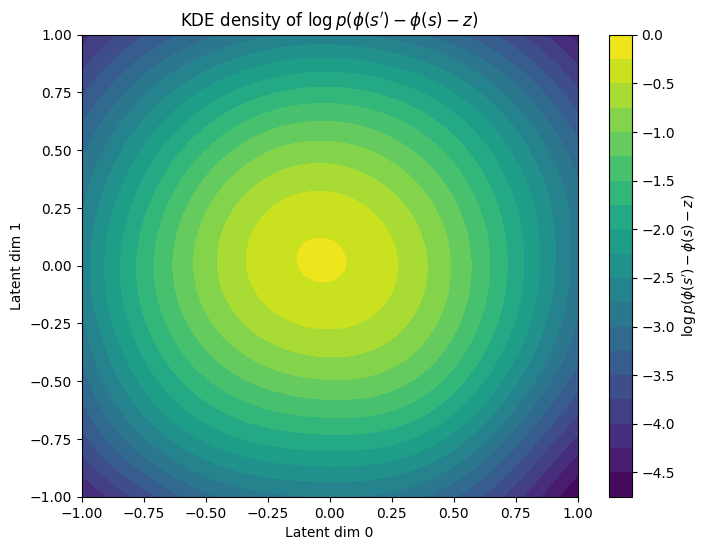

In [24]:
# plot heatmap of log p(phi(s') - phi(s) - z)
plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.contourf(X, Y, kde_scores.reshape(X.shape[0], X.shape[1]), 20, cmap='viridis')  # Create a filled contour plot (heatmap)
plt.colorbar(label="$\log p(\phi(s') - \phi(s) - z)$")  # Add a colorbar to interpret the colors
plt.xlabel('Latent dim 0')
plt.ylabel('Latent dim 1')
plt.title("KDE density of $\log p(\phi(s') - \phi(s) - z)$")
plt.show()

In [25]:
# plot log p(phi(s') - phi(s) - z) vs. ||phi(s') - phi(s) - z||_2^2
phisp_phis_z_replay_norms = np.square(phisp_phis_z_replay).sum(axis=-1)
kde_scores_z = kde_phisp_phis_z_replay.score_samples(phisp_phis_z_replay)

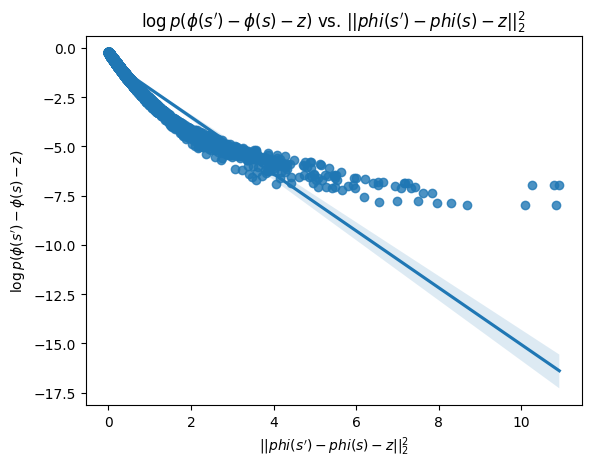

In [26]:
sns.regplot(x=phisp_phis_z_replay_norms, y=kde_scores_z)
plt.xlabel("$||phi(s') - phi(s) - z||_2^2$")
plt.ylabel("$\log p(\phi(s') - \phi(s) - z)$")
plt.title("$\log p(\phi(s') - \phi(s) - z)$ vs. $||phi(s') - phi(s) - z||_2^2$")
plt.show()

In [27]:
# create KDE estimator for [s, s']
sp_s_replay = np.concatenate((samples['obs'], samples['next_obs']), axis=-1)
# sp_s_replay = samples['next_obs'] - samples['obs']
kde_sp_s_replay = KernelDensity(bandwidth="scott").fit(sp_s_replay)
kde_scores_sp_s = kde_sp_s_replay.score_samples(sp_s_replay)

In [28]:
# plot log p(s, s') vs. ||phi(s') - phi(s)||_2^2
sns.regplot(x=phisp_phis_replay_norms, y=kde_scores_sp_s)
plt.xlabel("$||\phi(s') - \phi(s)||_2^2$")
plt.ylabel("$\log p(s, s')$")
plt.title("$\log p(s, s')$ vs. $||\phi(s') - \phi(s)||_2^2$")
plt.show()

NameError: name 'phisp_phis_replay_norms' is not defined

In [ ]:
# plot log p(phi(s), phi(s')) vs. ||phi(s') - phi(s)||_2^2
phisp_phis_replay = np.concatenate((phis_replay, phisp_replay), axis=-1)
phisp_phis_replay_norms = np.square(phisp_replay - phis_replay).sum(axis=-1)
kde_phisp_phis_replay = KernelDensity(bandwidth="scott").fit(phisp_phis_replay)
kde_scores = kde_phisp_phis_replay.score_samples(phisp_phis_replay)

In [ ]:
sns.regplot(x=phisp_phis_replay_norms, y=kde_scores)
plt.xlabel("$||\phi(s') - \phi(s)||_2^2$")
plt.ylabel("$\log p(\phi(s'), \phi(s))$")
plt.title("$\log p(\phi(s), \phi(s'))$ vs. $||\phi(s') - \phi(s)||_2^2$")
plt.show()

In [ ]:
# plot log p(s) vs. ||phi(s') - phi(s)||_2^2
# sp_s_replay = np.concatenate((samples['obs'], samples['next_obs']), axis=-1)
s_replay = samples['obs']
kde_s_replay = KernelDensity(bandwidth="scott").fit(s_replay)

In [ ]:
# plot 2d histogram
# Define the number of bins in each dimension
num_bins = 40

# Create the 2D histogram
plt.figure(figsize=(8, 6))  # Optional: set the figure size
X = s_replay[:, 0] * 0.62473416 + 0.00486117
Y = s_replay[:, 1] * 0.61958003 + 0.011312
plt.hist2d(X, Y, bins=num_bins, cmap='viridis')

# Add colorbar to interpret the color mapping
plt.colorbar(label='Number of points')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Histogram density of $s$")

# Show the plot
plt.show()

In [ ]:
# score entire meshgrid
kde_scores = kde_s_replay.score_samples(all_obs.numpy())

In [ ]:
xs = np.linspace(-40, 40)
ys = np.linspace(-40, 40)
X, Y = np.meshgrid(xs, ys)

# plot p(s) on the meshgrid 
plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.contourf(X, Y, kde_scores.reshape(X.shape[0], X.shape[1]), 20, cmap='viridis')  # Create a filled contour plot (heatmap)
plt.colorbar(label='$\log p(s)$')  # Add a colorbar to interpret the colors
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('$\log p(s)$ evaluated on meshgrid')
plt.show()

In [ ]:
# evaluate p(s) kde on replay samples
kde_scores = kde_s_replay.score_samples(s_replay)

In [ ]:
# norm of phi(s)
phis_replay_norms = np.square(phis_replay).sum(axis=-1)

# plot p(s) vs. ||phi(s)||_2^2
sns.regplot(x=phis_replay_norms, y=kde_scores)
plt.xlabel("$||\phi(s)||_2^2$")
plt.ylabel("$\log p(s)$")
plt.title("$\log p(s)$ vs. $||\phi(s)||_2^2$")
plt.show()

In [ ]:
# plot 
sns.regplot(x=phisp_phis_replay_norms, y=kde_scores_z, order=2)
plt.xlabel("$||\phi(s') - \phi(s)||_2^2$")
plt.ylabel("$\log p(\phi(s') - \phi(s) - z)$")
plt.title("$\log p(\phi(s') - \phi(s) - z)$ vs. $||\phi(s') - \phi(s)||_2^2$")
plt.show()

In [ ]:
# plot 2d histogram
# Define the number of bins in each dimension
num_bins = 30

# Create the 2D histogram
plt.figure(figsize=(8, 6))  # Optional: set the figure size
X = phisp_phis_replay[:, 0]
Y = phisp_phis_replay[:, 1]
plt.hist2d(X, Y, bins=num_bins, cmap='viridis')

# Add colorbar to interpret the color mapping
plt.colorbar(label='Number of points')

# Add labels and title
plt.xlabel('Latent dim 0')
plt.ylabel('Latent dim 1')
plt.title("Histogram density of $\phi(s') - \phi(s)$")

# Show the plot
plt.show()

In [ ]:
# meshgrid scores
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
all_coords = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        all_coords.append(np.array([X[i][j], Y[i][j]]))
all_coords = np.stack(all_coords)

kde_scores = kde_phisp_phis_replay.score_samples(all_coords) 

In [ ]:
# plot heatmap of log p(phi(s') - phi(s))
plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.contourf(X, Y, kde_scores.reshape(X.shape[0], X.shape[1]), 20, cmap='viridis')  # Create a filled contour plot (heatmap)
plt.colorbar(label="$\log p(\phi(s') - \phi(s))$")  # Add a colorbar to interpret the colors
plt.xlabel('Latent dim 0')
plt.ylabel('Latent dim 1')
plt.title("KDE density of $\log p(\phi(s') - \phi(s))$")
plt.show()

In [ ]:
# plot p(s' | s) by sampling lots of times from s using pi
INDEX = 8
init_obs = samples['obs'][INDEX] * np.sqrt(obs_var) + obs_mean
init_option = samples['options'][INDEX]

env = AntEnv(render_hw=100)
env.reset()
env.set_state(init_obs[:15], init_obs[15:])
start_obs = (env._get_obs() - obs_mean) / (np.sqrt(obs_var) + 1e-8)

start_obs_torch = torch.from_numpy(start_obs).float().unsqueeze(0)
options_torch = torch.from_numpy(init_option).float().unsqueeze(0)
obs_with_option = algo._get_concat_obs(option_policy.process_observations(start_obs_torch), options_torch)
with torch.no_grad():
    action_dists, *_ = option_policy(obs_with_option)

all_next_states = []

NUM_SAMPLES = 1000
# new_actions_pre_tanh, new_actions = action_dists.rsample_with_pre_tanh_value()
for _ in range(NUM_SAMPLES):
    new_actions_pre_tanh, new_actions = action_dists.rsample_with_pre_tanh_value()
    next_o, r, d, env_info = env.step(new_actions.numpy().flatten())
    all_next_states.append((next_o - obs_mean) / (np.sqrt(obs_var) + 1e-8))
    env.set_state(init_obs[:15], init_obs[15:])  

In [ ]:
# compute all necessary components
s = start_obs_torch.repeat((NUM_SAMPLES, 1))
sp = torch.from_numpy(np.stack(all_next_states)).float()
with torch.no_grad():
    phis = traj_encoder(s).mean.numpy()
    phisp = traj_encoder(sp).mean.numpy()
    
phisp_phis_norm_squared = np.square(phisp - phis).sum(axis=-1)

# kde on sp
kde_sp = KernelDensity(bandwidth="scott").fit(sp.numpy())

In [ ]:
# score sp with kde
kde_scores = kde_sp.score_samples(sp.numpy())

In [ ]:
# plot p(s' | s) vs. ||phi(s') - phi(s)||_2^2
sns.regplot(x=phisp_phis_norm_squared, y=kde_scores)
plt.xlabel("$||\phi(s') - \phi(s)||_2^2$")
plt.ylabel("$\log p(s' | s)$")
plt.title("$\log p(s' | s)$ vs. $||\phi(s') - \phi(s)||_2^2$")
plt.show()

In [ ]:
# s6 -> idx 3
# s5 -> idx 4
# s4 -> idx 5
# s3 -> idx 6
# s2 -> idx 7
# s1 -> idx 8
# print (x, y) of all states
s6 = samples['obs'][3] * np.sqrt(obs_var) + obs_mean
s5 = samples['obs'][4] * np.sqrt(obs_var) + obs_mean
s4 = samples['obs'][5] * np.sqrt(obs_var) + obs_mean
s3 = samples['obs'][6] * np.sqrt(obs_var) + obs_mean
s2 = samples['obs'][7] * np.sqrt(obs_var) + obs_mean
s1 = samples['obs'][8] * np.sqrt(obs_var) + obs_mean

all_states = [s1, s2, s3, s4, s5, s6]
for i, s in enumerate(all_states, 1):
    X = s[0]
    Y = s[1]
    print(f'S{i} X: {X:.2f} Y:{Y:.2f}')